# **ECS 7001 - NN & NNLP**

## **Lab 3: LSTM for Text Classification**

<br>



### **1. Getting the Dataset**

imdb dataset. This is a dataset of 25,000 movie reviews from IMDB, labeled by sentimen - positive (1) or negative (0). 
<br>



In [1]:
import keras
import tensorflow as tf
import numpy as np

imdb = keras.datasets.imdb

In [2]:
%%capture

# we'll use the most frequent 10000 words in the vocabulary
VOCAB_SIZE = 10000

# 0 is reserved for ‘<PAD>’, 1 for ‘<START>’ and 2 for ‘<UNK>’ i.e. words not in vocabulary
# the documentation says index_from = 3 but actually uses the value as an offset. The words
# in the dictionary are indexed from 1 by default so, saying index_from=3 means any actual
# words would start from 4 (1+3) and index 3 will be left unused. We use index_from=offset=2 to avoid this
# If you want to explore this further, you may look up the source_code for load_data here
# https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/datasets/imdb.py#L31-L162
OFFSET = 2

# for more information on the load_data method, type(help(load_data))
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=VOCAB_SIZE, index_from=OFFSET)


In [3]:
print(train_data.shape)

(25000,)


***Sanity Check***

Each instance in the training data is a list of word indices representing the words in a movie review.

Each label is 1 if that review is positive, else 0.

In [4]:
print('Sample review:', train_data[0])

Sample review: [1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 2, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 2, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 2, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 5243, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 2, 7, 3, 106, 116, 5951, 14, 255, 3, 2, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 2, 1028, 12, 103, 87, 3, 380, 14, 296, 97, 31, 2070, 55, 25, 140, 5, 193, 7485, 17, 3, 225, 21, 20, 133, 475, 25, 479, 4, 143, 29, 5534, 17, 50, 35, 27, 223, 91, 24, 103, 3, 225, 64, 15, 37, 1333, 87, 11, 15, 282, 4, 15, 4471, 112, 102, 31, 14, 15, 5344, 18, 177, 31]


In [5]:
print('\n Sample label:', train_labels[0])


 Sample label: 1


### **2. Readying the Inputs for the LSTM**

The movie reviews are of different lengths. The standard way of dealing with varying length inputs is to ***pad*** or ***truncate*** each sentence to a fixed length (which we choose heuristically). 



In [6]:
from keras.preprocessing.sequence import pad_sequences


MAX_LENGTH = 500

# YOUR CODE GOES HERE
padded_train_data = tf.keras.preprocessing.sequence.pad_sequences(
                    train_data, maxlen=MAX_LENGTH, dtype='int32', padding='pre',
                    truncating='pre', value=0.)

padded_test_data = tf.keras.preprocessing.sequence.pad_sequences(
                    test_data, maxlen=MAX_LENGTH, dtype='int32', padding='pre',
                    truncating='pre', value=0)


In [7]:
print('Length of sample train_data before preprocessing:', len(train_data[0]))
print('Length of sample train_data after preprocessing:', len(padded_train_data[0]))
print('Sample train data:', padded_train_data[0])

Length of sample train_data before preprocessing: 218
Length of sample train_data after preprocessing: 500
Sample train data: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  

### **3. Building the Model**

Use the keras Model API to build a classification model.


In [8]:
from keras.layers import Input, Embedding, Dense, LSTM
from keras.models import Model
from keras.models import Sequential

EMBED_SIZE = 100

Input = Input((500,), dtype='int32')
Embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_LENGTH, mask_zero=True)(Input)
LSTM = LSTM(100, return_sequences=False)(Embedding)
DenseOutput = Dense(1, activation='softmax')(LSTM)
model = Model(inputs=[Input], outputs=[DenseOutput])  
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

***Sanity Check***

Print the model summary and visualize it using vis_utils.

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


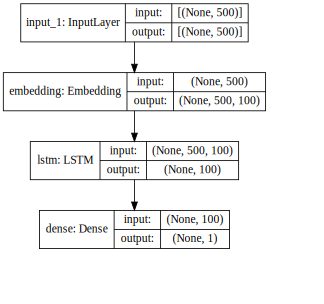

In [10]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  


### **4. Training the Model**



**Step 1: Getting a validation dataset**

Before we begin training, you will split the padded training data into training and validation data. To avoid losing too much training data, use 2000 samples (i.e 8%) for validation and the other 23000 for training.

We will do this using the sklearn train_test_split function. 

In [11]:
from sklearn.model_selection import train_test_split

train_x, validation_x, train_y, validation_y = train_test_split(padded_train_data, train_labels, test_size=0.08) 

Alternatively, we could have chosen to set validation_size=0.08 in our model.fit() function below instead of passing in a separate validation dataset.

**Step 2: Training the model**

We will use model.fit() to train the model. We will set our batch_size to 1000, which means the model will train int(23000/1000) batches each epoch. In other words, at each epoch the model will train 23 batches, each one consisting of 1000 movie reviews.

In [12]:
history = model.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 87s 4s/step - loss: 0.6810 - accuracy: 0.5031 - val_loss: 0.5579 - val_accuracy: 0.5105
Epoch 2/6
23/23 [==============================] - 96s 4s/step - loss: 0.4633 - accuracy: 0.4939 - val_loss: 0.3559 - val_accuracy: 0.5105
Epoch 3/6
23/23 [==============================] - 116s 5s/step - loss: 0.2698 - accuracy: 0.4960 - val_loss: 0.3152 - val_accuracy: 0.5105
Epoch 4/6
23/23 [==============================] - 126s 6s/step - loss: 0.2167 - accuracy: 0.5011 - val_loss: 0.3258 - val_accuracy: 0.5105
Epoch 5/6
23/23 [==============================] - 130s 6s/step - loss: 0.1673 - accuracy: 0.5019 - val_loss: 0.3352 - val_accuracy: 0.5105
Epoch 6/6
23/23 [==============================] - 135s 6s/step - loss: 0.1284 - accuracy: 0.5004 - val_loss: 0.3382 - val_accuracy: 0.5105


**Step 3: Visualize the model plot**

In [13]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

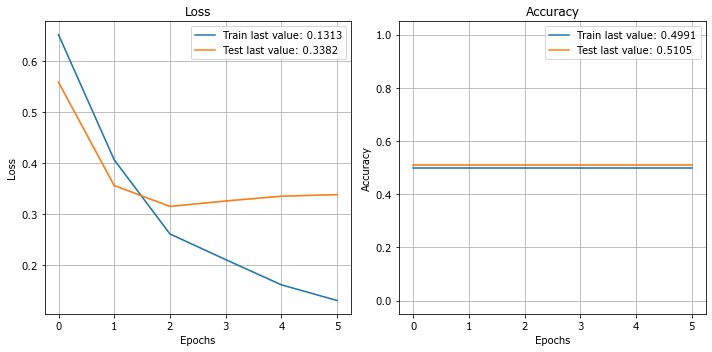

In [14]:
plot_history(history.history, path="standard.png")
plt.show()

#Optimal number of epochs is 2, before the train and test value starts diverging which indicates overfitting

**Based on the accuracy plot, what do you think the optimal stopping point for your model should
have been?**

### **5. Evaluating the Model on the Test Data**

Evaluate the model on the padded test data using the code in the following cell block.

In [15]:
# YOUR CODE TO EVALUATE THE MODEL ON TEST DATA GOES HERE
results = model.evaluate(padded_test_data,test_labels)
print('test_loss:', results[0], 'test_accuracy:', results[1])

782/782 [==============================] - 43s 54ms/step - loss: 0.3567 - accuracy: 0.5000
test_loss: 0.3566696047782898 test_accuracy: 0.5


###**6. Extracting the Word Embeddings**

Extract the word embeddings from the embedding layer model.

In [16]:
# YOUR CODE GOES HERE
word_embeddings = model.get_layer('embedding').get_weights()[0]
word_embeddings

array([[-0.04557038, -0.03877534, -0.04124003, ..., -0.03446183,
         0.00269998, -0.00519045],
       [ 0.01825261, -0.06003053, -0.04332699, ..., -0.04141725,
         0.02803426, -0.02638284],
       [-0.04118242,  0.04005654, -0.03575661, ...,  0.01209291,
        -0.0450852 ,  0.00369033],
       ...,
       [-0.07311087, -0.0745412 , -0.01144449, ...,  0.05291119,
         0.00307731, -0.01723799],
       [ 0.01195007, -0.03758162,  0.02753666, ..., -0.01293865,
         0.0177248 , -0.0324871 ],
       [-0.0218468 , -0.02333747,  0.04274999, ...,  0.01014672,
         0.03022391,  0.00179847]], dtype=float32)

In [17]:
print('Shape of word_embeddings:', word_embeddings.shape)

Shape of word_embeddings: (10000, 100)


###**7. Visualizing the Reviews**






**Step 1: Create a word2idx dictionary**

Create the word2idx dictionary using the following lines of code.

In [18]:
# in this dictionary, the words start from 1, 0 is reserved for padding but 
# <start> and <unknown> are not accounted for.
word_indices = imdb.get_word_index()

# so we shift each original word two places to make room for the two new tokens
offset = 2
word2idx = {k:(v+offset) for k,v in word_indices.items() if v < 9998}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2


**Step 2: Create a the idx2word dictionary**

In [19]:
# YOUR CODE GOES HERE
idx2word = {value:key for key, value in word2idx.items()}


**Step 3: Visualize sample review**

View a sample review text using the lines of code below:

In [20]:
print(' '.join(idx2word[idx] for idx in train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

###**8. Visualizing the Word_Embeddings**

Visualize the word embeddings for 10 of the words using pandas DataFrame like we did in lab 3

In [21]:
# YOUR CODE GOES HERE
from pandas import DataFrame
print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

                 0         1         2         3         4         5   \
woods     -0.045570 -0.038775 -0.041240 -0.003276  0.015256  0.014055   
hanging    0.018253 -0.060031 -0.043327  0.002415  0.029853  0.003753   
woody     -0.041182  0.040057 -0.035757 -0.031785  0.026067 -0.033924   
arranged  -0.023427  0.017961  0.047362 -0.022628  0.035152  0.022004   
bringing   0.045294  0.026588 -0.011737 -0.015982 -0.007109 -0.035602   
wooden     0.021925  0.017110 -0.022960 -0.025053 -0.002506 -0.047871   
errors    -0.025471 -0.012394 -0.017043 -0.009020 -0.037702 -0.018152   
dialogs   -0.025159  0.014821  0.003022  0.036705  0.008035  0.020782   
kids       0.051429  0.022972  0.035211  0.022226 -0.001029  0.011744   
uplifting -0.024696  0.026221  0.014512  0.048584  0.019013 -0.022897   

                 6         7         8         9   ...        90        91  \
woods      0.001809  0.035832 -0.043108  0.021571  ... -0.020616  0.026001   
hanging    0.001735  0.012316 -0.034038 

###**9. Plot your Word Embeddings using t-SNE**


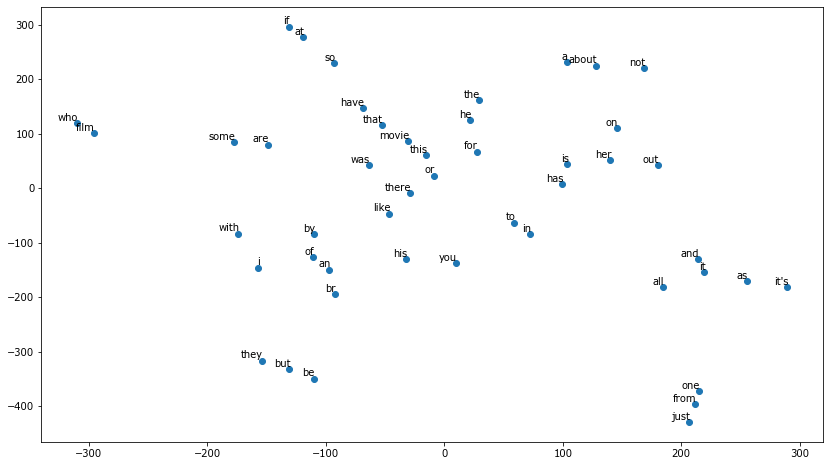

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50

# don't plot the special tokens
start = 3
T = tsne.fit_transform(word_embeddings[start:plot_only, :])
labels = [idx2word[i] for i in range(start, plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        




1. Create a new model that is a copy of the model step 3. To this new model,add two dropout layers, one between the embedding layer and the LSTM layer and another between the LSTM layer and the output layer. Repeat steps 4 and 5 for this model. What do you observe?

2. Experiment with training the model with batch sizes of 1, 32, len(training_data). What do you observe?




# Q 10 1.

In [23]:
from keras.layers import Input, Embedding, Dense, LSTM
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dropout

EMBED_SIZE = 100


Input = Input((500,), dtype='int32')
Embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_LENGTH, mask_zero=True)(Input)
Droupout1 = Dropout(0.5)(Embedding)
LSTM = LSTM(100, return_sequences=False)(Droupout1)
Droupout2 = Dropout(0.5)(LSTM)
DenseOutput = Dense(1, activation='softmax')(Droupout2)
model = Model(inputs=[Input], outputs=[DenseOutput])  
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [24]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
dropout (Dropout)            (None, 500, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________

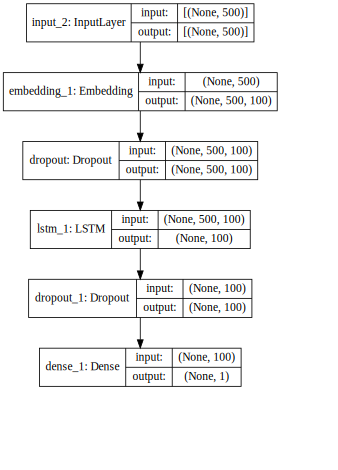

In [25]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  


In [26]:
from sklearn.model_selection import train_test_split

train_x, validation_x, train_y, validation_y = train_test_split(padded_train_data, train_labels, test_size=0.08) 

In [27]:
history = model.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 150s 6s/step - loss: 0.6869 - accuracy: 0.5037 - val_loss: 0.6047 - val_accuracy: 0.5060
Epoch 2/6
23/23 [==============================] - 150s 7s/step - loss: 0.4958 - accuracy: 0.4996 - val_loss: 0.3608 - val_accuracy: 0.5060
Epoch 3/6
23/23 [==============================] - 149s 6s/step - loss: 0.3001 - accuracy: 0.5040 - val_loss: 0.3059 - val_accuracy: 0.5060
Epoch 4/6
23/23 [==============================] - 150s 7s/step - loss: 0.2247 - accuracy: 0.5019 - val_loss: 0.2893 - val_accuracy: 0.5060
Epoch 5/6
23/23 [==============================] - 146s 6s/step - loss: 0.1877 - accuracy: 0.5016 - val_loss: 0.3011 - val_accuracy: 0.5060
Epoch 6/6
23/23 [==============================] - 146s 6s/step - loss: 0.1561 - accuracy: 0.4980 - val_loss: 0.3504 - val_accuracy: 0.5060


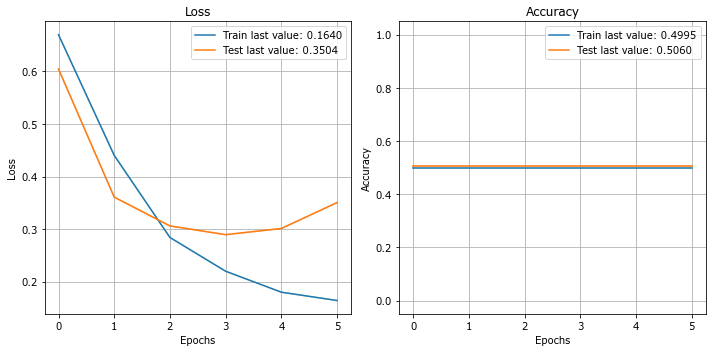

In [28]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

plot_history(history.history, path="standard.png")
plt.show()

In [29]:
results = model.evaluate(padded_test_data,test_labels)
print('test_loss:', results[0], 'test_accuracy:', results[1])

782/782 [==============================] - 50s 62ms/step - loss: 0.3539 - accuracy: 0.5000
test_loss: 0.35385558009147644 test_accuracy: 0.5


# Q 10 2.

In [31]:
# # Batch size = 1

history = model.fit(train_x, train_y, epochs=6, batch_size=1, validation_data=(validation_x, validation_y))

In [ ]:
# Batch size = 32

history = model.fit(train_x, train_y, epochs=6, batch_size=32, validation_data=(validation_x, validation_y))

In [ ]:
# Batch size = len(training_data)

history = model.fit(train_x, train_y, epochs=6, batch_size=len(train_data), validation_data=(validation_x, validation_y))